In [1]:
import matplotlib.pyplot as plt
import numpy as np

In [26]:
import src.models.train_model
from src.models.train_model import CustomCropToLowerXPercent

In [43]:
import torch
from typing import Union
from torchvision import datasets, transforms, models
from torch.utils.data.sampler import SubsetRandomSampler
import torch.nn.functional as F
import math

In [122]:
class CustomCropToLowerXPercent2:
    """crops an image to the bottom x percent of an image;
    can be integrated to a pytorch.transform.Compose pipeline
    """
    def __init__(self, height_perc: int):
        if isinstance(height_perc, int):
            self.height_perc = height_perc
        else:
            self.height_perc = 100

    def __call__(self, img):
        width, height = img.size
        new_height = math.floor(height * self.height_perc / 100)
        cropped = transforms.functional.crop(img,
                                             top=height-new_height, 
                                             left=0, 
                                             height=new_height, width=width)
        #print("cropped", cropped.shape)
        # top: int, left: int, height: int, width: int
        return cropped
    

In [123]:
def load_split_train_valid(data_dir: str, valid_size = .2) -> \
    Union[torch.utils.data.DataLoader, torch.utils.data.DataLoader]:
    """loads the data from a given path

    Args:
        data_dir (str): path to data directory, including subfolders

        valid_size (float, optional): size of validation set. 
            Defaults to .2.

    Returns:
        Union[torch.utils.data.DataLoader, torch.utils.data.DataLoader]: 
            iteratable train and validation sets
    """
    # define image transformations
    resize_size = (500, 500)
    train_transforms = transforms.Compose([transforms.Resize(resize_size),
                                        CustomCropToLowerXPercent2(33),
                                           transforms.ToTensor(),
                                       ])    
    valid_transforms = transforms.Compose([transforms.Resize(resize_size),
                                        CustomCropToLowerXPercent(33),
                                      transforms.ToTensor(),
                                      ])    
    
    # load image data and apply transformations
    train_data = datasets.ImageFolder(data_dir,       
                    transform=train_transforms)
    valid_data = datasets.ImageFolder(data_dir,
                    transform=valid_transforms)    

    # define split indices
    num_train = len(train_data)
    indices = list(range(num_train))
    split = int(np.floor(valid_size * num_train))
    np.random.shuffle(indices)
    train_idx, valid_idx = indices[split:], indices[:split]
    train_sampler = SubsetRandomSampler(train_idx)
    valid_sampler = SubsetRandomSampler(valid_idx)

    # define data loader 
    train_loader = torch.utils.data.DataLoader(train_data,
                   sampler=train_sampler, batch_size=64)
    valid_loader = torch.utils.data.DataLoader(valid_data,
                   sampler=valid_sampler, batch_size=64)

    return train_loader, valid_loader

In [124]:
data_dir = "/home/thomas/cargorocket/repo/data/example_dataset/sorted/"
train_loader, val_loader = load_split_train_valid(data_dir=data_dir)

In [125]:
arr = next(iter(train_loader))[0]
print(arr.shape)

torch.Size([10, 3, 165, 500])


In [126]:
arr.min(), arr.max()

(tensor(0.), tensor(1.))

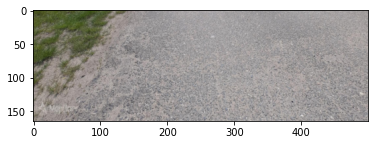

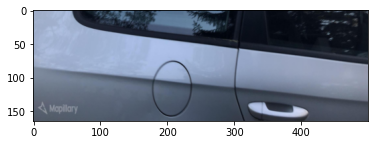

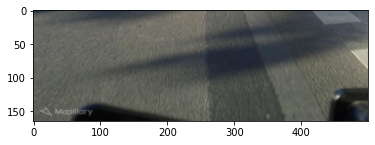

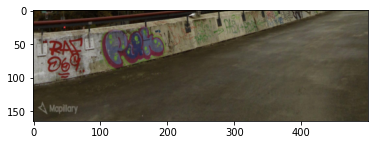

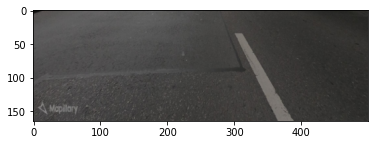

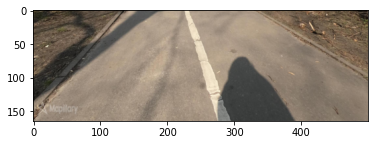

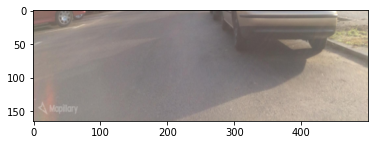

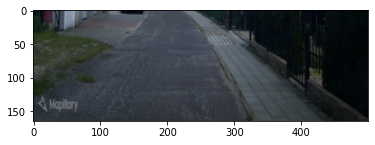

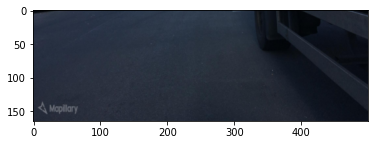

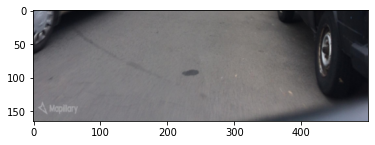

In [127]:
for elem in range(arr.shape[0]):
    img = arr[elem].numpy().transpose((1,2,0))
    plt.imshow(img)
    plt.show()